In [2]:
import contextily as ctx
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
from cartiflette import carti_download

In [4]:
# Importation carte Var
from cartiflette import carti_download
communes_borders = carti_download(
    crs = 4326,
    values = ["13"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

In [5]:
# extraction des données de Marseille
marseille = communes_borders.loc[communes_borders['INSEE_COM'] == '13055']
marseille = marseille.to_crs(3857)
marseille.head()

,INSEE_DEP,INSEE_REG,ID,NOM,INSEE_COM,STATUT,POPULATION,AREA,INSEE_COG,ARR,...,AAV2020,TAAV2017,TDAAV2017,CATEAAV2020,BV2012,LIBELLE_DEPARTEMENT,LIBELLE_REGION,PAYS,SOURCE,geometry
118,13,93,ARR_MUNI0000000009761157,Marseille 7e Arrondissement,13055,Arrondissement municipal,34697,NaN,13207,133,...,003,4,42,11,13055,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,France,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((588589.603 5354588.385, 588624..."
119,13,93,ARR_MUNI0000000009761407,Marseille 9e Arrondissement,13055,Arrondissement municipal,76633,NaN,13209,133,...,003,4,42,11,13055,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,France,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((600832.488 5344321.163, 600838..."
120,13,93,ARR_MUNI0000000009761163,Marseille 1er Arrondissement,13055,Arrondissement municipal,39893,NaN,13201,133,...,003,4,42,11,13055,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,France,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((598024.142 5356365.151, 599107.65 53..."
121,13,93,ARR_MUNI0000000009761162,Marseille 2e Arrondissement,13055,Arrondissement municipal,25217,NaN,13202,133,...,003,4,42,11,13055,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,France,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((598330.103 5357993.406, 598277..."
122,13,93,ARR_MUNI0000000009761161,Marseille 3e Arrondissement,13055,Arrondissement municipal,51792,NaN,13203,133,...,003,4,42,11,13055,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,France,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((600366.515 5360257.254, 600313.439 5..."


In [6]:
# Importation des données concernant les points d'apport volontaire
url = 'https://www.data.gouv.fr/api/1/datasets/r/e46c6879-49e7-4727-8f3b-62df90ac5a5a'
bacs_data = pd.read_csv(url, sep = ';')


In [7]:
# Extraction des données concernant Marseille
bacs_marseille = bacs_data.loc[(bacs_data['Code Commune INSEE'] > 13200) & (bacs_data['Code Commune INSEE'] < 13217)]

In [8]:
bacs_marseille.info()

<class 'pandas.DataFrame'>
Index: 5835 entries, 43 to 12772
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   OBJECTID                          5835 non-null   int64  
 1   Ex identifiant CT                 5674 non-null   str    
 2   Date création mobilier            5818 non-null   str    
 3   Famille Osis                      5835 non-null   str    
 4   Type de colonne                   5830 non-null   str    
 5   Modèle                            4800 non-null   str    
 6   Volume intérieur m3               3353 non-null   float64
 7   longitude                         5835 non-null   float64
 8   latitude                          5835 non-null   float64
 9   Date de mise à jour de la donnée  5835 non-null   str    
 10  Code Commune INSEE                5835 non-null   float64
 11  Commune                           5835 non-null   str    
 12  Position            

In [9]:
# Modification du nom et du type de 'Code Commune INSEE' pour futur merge
bacs_marseille = bacs_marseille.rename({
    'Code Commune INSEE' : 'INSEE_COG',
    'Volume intérieur m3' : 'volume'
    }, axis = 1)
bacs_marseille['INSEE_COG'] = bacs_marseille['INSEE_COG'].astype(str)

In [10]:
# Données manquantes sur le volume de points d'apport
print(bacs_marseille['volume'].isna().mean())

# Différents volumes renseignés
bacs_marseille['volume'].value_counts()


# 43% des données manquantes sur le volume, c'est beaucoup!
# Ne prendre que les valeurs connues, c'est beaucoup de perte d'info...
# On remplace les Nan par la valeur moyenne?
# # QUID des valeurs 2000 et 3000? erreur de saisie -> 2 et 3? ou décharge municipale??

0.42536418166238216


volume
3.0       2110
3.2        668
4.0        242
2.0        144
5.0        120
2.2         48
1.8         19
3000.0       1
2000.0       1
Name: count, dtype: int64

In [11]:
# Remplacement des valeurs 2000 et 3000 dans l'hypothèse d'une erreur de saisie
bacs_marseille['volume'] = bacs_marseille['volume'].replace({2000.0 : 2.0, 3000.0 : 3.0})

# Remplacement des valeurs absentes sur le volume par la moyenne des valeurs connues
bacs_marseille['volume'] = bacs_marseille['volume'].fillna(bacs_marseille['volume'].mean())

In [12]:
# conversion en geodataframe pour affichage des points sur la carte
bacs_marseille_map = gpd.GeoDataFrame(bacs_marseille, geometry=gpd.points_from_xy(bacs_marseille['longitude'], bacs_marseille['latitude'], crs="EPSG:4326"))
bacs_marseille_map = bacs_marseille_map.to_crs(3857)

In [13]:
# Volume total des points d'apport par arrondissement
vol_arr = bacs_marseille.groupby(['INSEE_COG'], as_index = False).sum(numeric_only = True)
vol_arr['INSEE_COG'] = vol_arr['INSEE_COG'].apply(lambda x : str(x)[:-2])

In [14]:
# Data sur la population et la densité par arrondissement en 2022 (pas trouvé de source plus pratique que de renseigner à la main ?!)
densite_pop = {
    'INSEE_COG' : np.arange(13201, 13217).astype(str),
    'population' : [38482, 24153, 55653, 49744, 45020, 38804, 34866, 83414, 76347, 59852, 59033, 64276, 93425, 59230, 79501, 15415],
    'densite' : [21378.9, 4792.3, 21405.0, 17153.1, 20098.2, 18478.1, 6011.4, 4496.7, 1206.7, 5521.4, 1756.9, 4558.6, 3320.0, 3602.8, 4704.2, 945.7]

}
densite_pop = pd.DataFrame(densite_pop)

In [15]:
# merge des données de carte, de population et de volume des points d'apport
marseille = marseille.merge(right = densite_pop, on = 'INSEE_COG')
marseille = marseille.merge(vol_arr, on = 'INSEE_COG')

In [16]:
# Calcul des taux volume_total/habitant et volume_total/densité
marseille['vol/hab'] = marseille['volume']/marseille['population']
marseille['vol/dens'] = marseille['volume']/marseille['densite']


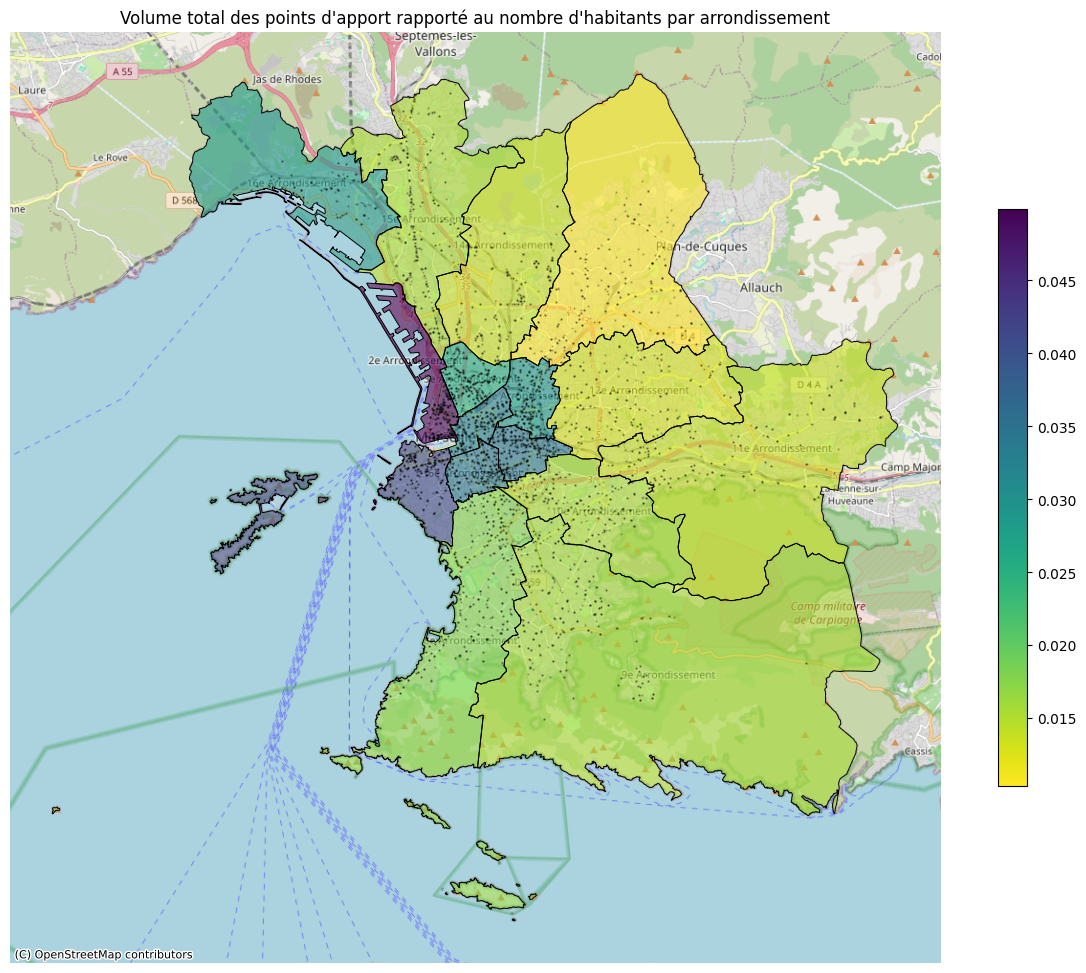

In [17]:
import contextily as ctx


base = marseille.boundary.plot(edgecolor = 'black', linewidth = 0.7, figsize = (15,15))
marseille.plot(ax = base, column = 'vol/hab', cmap = 'viridis_r', alpha = 0.6, legend = True, legend_kwds={'shrink': 0.5})
bacs_marseille_map.plot(ax = base, color = 'Black', markersize = 0.5, alpha = 0.2)

ctx.add_basemap(ax = base, source = ctx.providers.OpenStreetMap.Mapnik)


base.set_axis_off()

base.set_title("Volume total des points d'apport rapporté au nombre d'habitants par arrondissement");


In [ ]:
map = folium.Map(
    location = [43.3, 5.4],
    tiles = 'OpenStreetMap',
    zoom_start = 12,
    max_zoom=23,
    control_scale=True)

bacs_marseille_map.explore(
    m = map,
    marker_kwds=dict(radius=1, fill=True),
    color = 'Grey'
)

marseille.explore(
    m = map, 
    column = 'vol/hab',
    tooltip = ['NOM', 'volume', 'population'],
    popup = True,
    cmap = 'autumn_r',
    legend = False)


map_title = "Volume total des points d'apport rapporté au nombre d'habitants par arrondissement"
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))


map.save('../cartes/map_vol_nb_hab_arr.html')



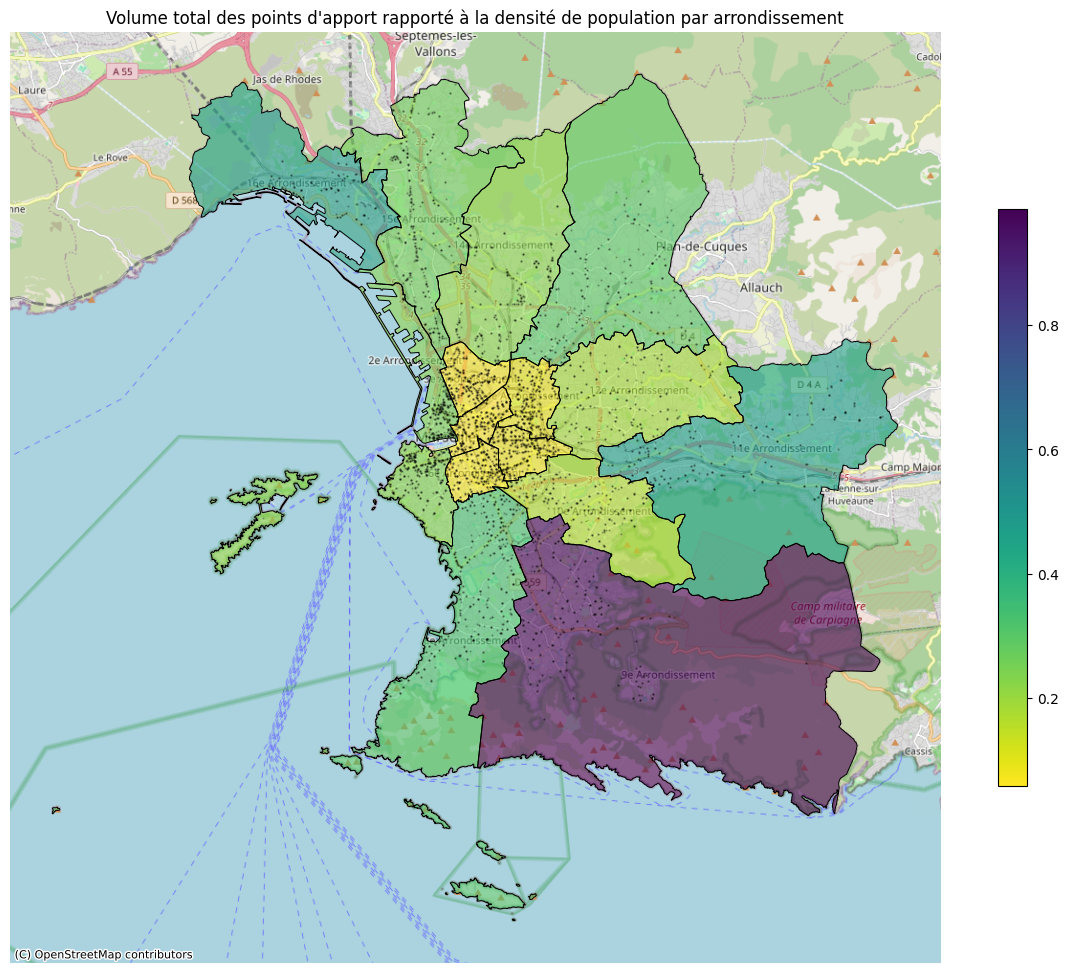

In [19]:
base = marseille.boundary.plot(edgecolor = 'black', linewidth = 0.7, figsize = (15,15))

marseille.plot(ax = base, column = 'vol/dens', cmap = 'viridis_r', alpha = 0.6, legend = True, legend_kwds={'shrink': 0.5})

bacs_marseille_map.plot(ax = base, color = 'Black', markersize = 0.5, alpha = 0.2)

ctx.add_basemap(ax = base, source = ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off()

base.set_title("Volume total des points d'apport rapporté à la densité de population par arrondissement");

In [ ]:
map = folium.Map(
    location = [43.3, 5.4],
    tiles = 'OpenStreetMap',
    zoom_start = 12,
    max_zoom=23,
    control_scale=True)

bacs_marseille_map.explore(
    m = map,
    marker_kwds=dict(radius=1, fill=True),
    color = 'Grey'
)

marseille.explore(
    m = map, 
    column = 'vol/dens',
    tooltip = ['NOM', 'volume', 'population'],
    popup = True,
    cmap = 'autumn_r',
    legend = False)


map_title = "Volume total des points d'apport rapporté à la densité de population par arrondissement"
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))


map.save('../cartes/map_vol_dens_arr.html')

